## Tutorial Part B: Short-term landscape evolution in response to mass wasting events
### CSDMS ESPIn 2025 Group Project: Event-Mass Wasting-Short-term channel evolution Team

Contributors (listed in the alphabetic order of last name): 
- **Sayan Das**          *(Indiana University (IU) Bloomington, Department of Earth & Atmospheric Sciences)*
- **Dewan Md. Enamul Haque**          *(Louisiana State University (LSU), Department of Geology & Geophysics)*
- **Fatemeh Shacheri**   *(Virginia Tech (VT), Biological Systems Engineering)*

---


**Short summary:** In this tutorial, the user defines the rectangular geometry of a landslide, parameterizes MassWastingRunout (MWR), and runs it on a synthetic steep hillslope terrain. The modeled runout of the landslide is presented as debris flow channel. Using the topographic elevation and soil thickness post mass wasting as reference, the user simulates the evolution of a debris flow channel in response to hillslope diffusion and sediment transport.

References:
* Shobe, C. M., Tucker, G. E., and Barnhart, K. R.: The SPACE 1.0 model: a Landlab component for 2-D calculation of sediment transport, bedrock erosion, and landscape evolution, Geosci. Model Dev., 10, 4577-4604, https://doi.org/10.5194/gmd-10-4577-2017, 2017. 
* Campforts, B., Shobe, C. M., Steer, P., Vanmaercke, M., Lague, D., and Braun, J.: HyLands 1.0: a hybrid landscape evolution model to simulate the impact of landslides and landslide-derived sediment on landscape evolution, Geosci. Model Dev., 13, 3863–3886, https://doi.org/10.5194/gmd-13-3863-2020, 2020.
* GravelBedrockEroder: rock incision, bed-load transport, and downstream abrasion in a river network. https://landlab.readthedocs.io/en/latest/reference/components/gravel_bedrock_eroder.html
* Keck, J., Istanbulluoglu, E., Campforts, B., Tucker, G., and Horner-Devine, A.: A landslide runout model for sediment transport, landscape evolution, and hazard assessment applications, Earth Surf. Dynam., 12, 1165–1191, https://doi.org/10.5194/esurf-12-1165-2024, 2024.
---

### What are debris-flow channels?

Debris flow channels can be defined as the drainage route taken by debris from mass wasting events. They are gravity-driven flows of sediment originating from hillslopes or landslide scars and depositing material in downstream fans or alluvial zones.

They are found on hillslopes and can form as a result of different factors such as:

- **Earthquakes**

<img src="Debris_flow_pics/earthq_flow.PNG" alt="drawing" width="400"/>

**Fig.1.** Debris flow channels after 2008 Wenchuan earthquake (Source: Fan et. al., 2019)

- **Heavy precipitation from storms**

<img src="Debris_flow_pics/JPC_Bear_Canyon_debris_flow_scar.jpg" alt="drawing" width="400"/>

**Fig.2.** Debris flow channels in Bear Canyon, Arizona, after a tropical storm (Source: Joseph Cook)

- **Forest fires**

<img src="Debris_flow_pics/forestfire.jpg" alt="drawing" width="400"/>

**Fig.3.** Debris flow channels after forest fire (Source: Charlotte Observer)

### I. Mass Wasting Runout (MWR) overview

- MWR models the downslope progression of mass wasting processes such as debris flows or dry debris avalanches.

- Mass continuity is central to model conceptualization; at any node, the incoming flux (q_I), erosion (E) and aggradation (A) determine outgoing flux (q_O) and ultimately the runout extent and how the landscape evolves. 

<div>    
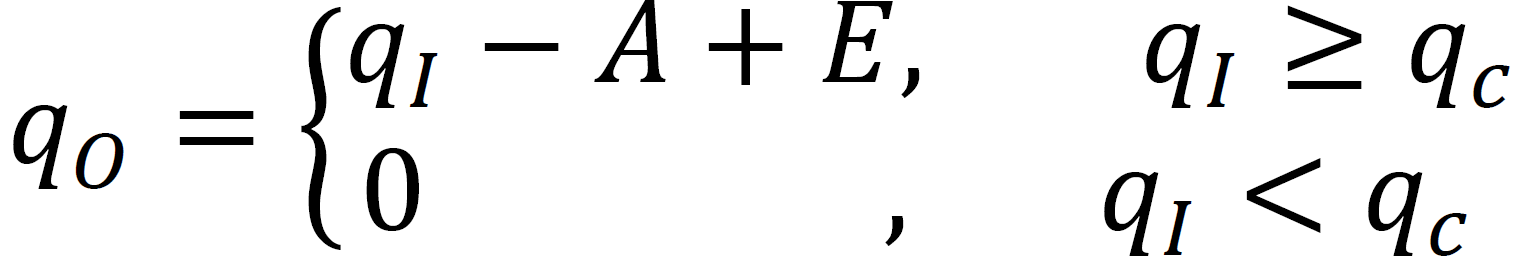
<div>
    
    
- MWR uses a set of rules and algorithms to numerically represent the release of the mass wasting source material and erosion, deposition and vegetation/debris impacts on the runout process as illustrated below:

<div>
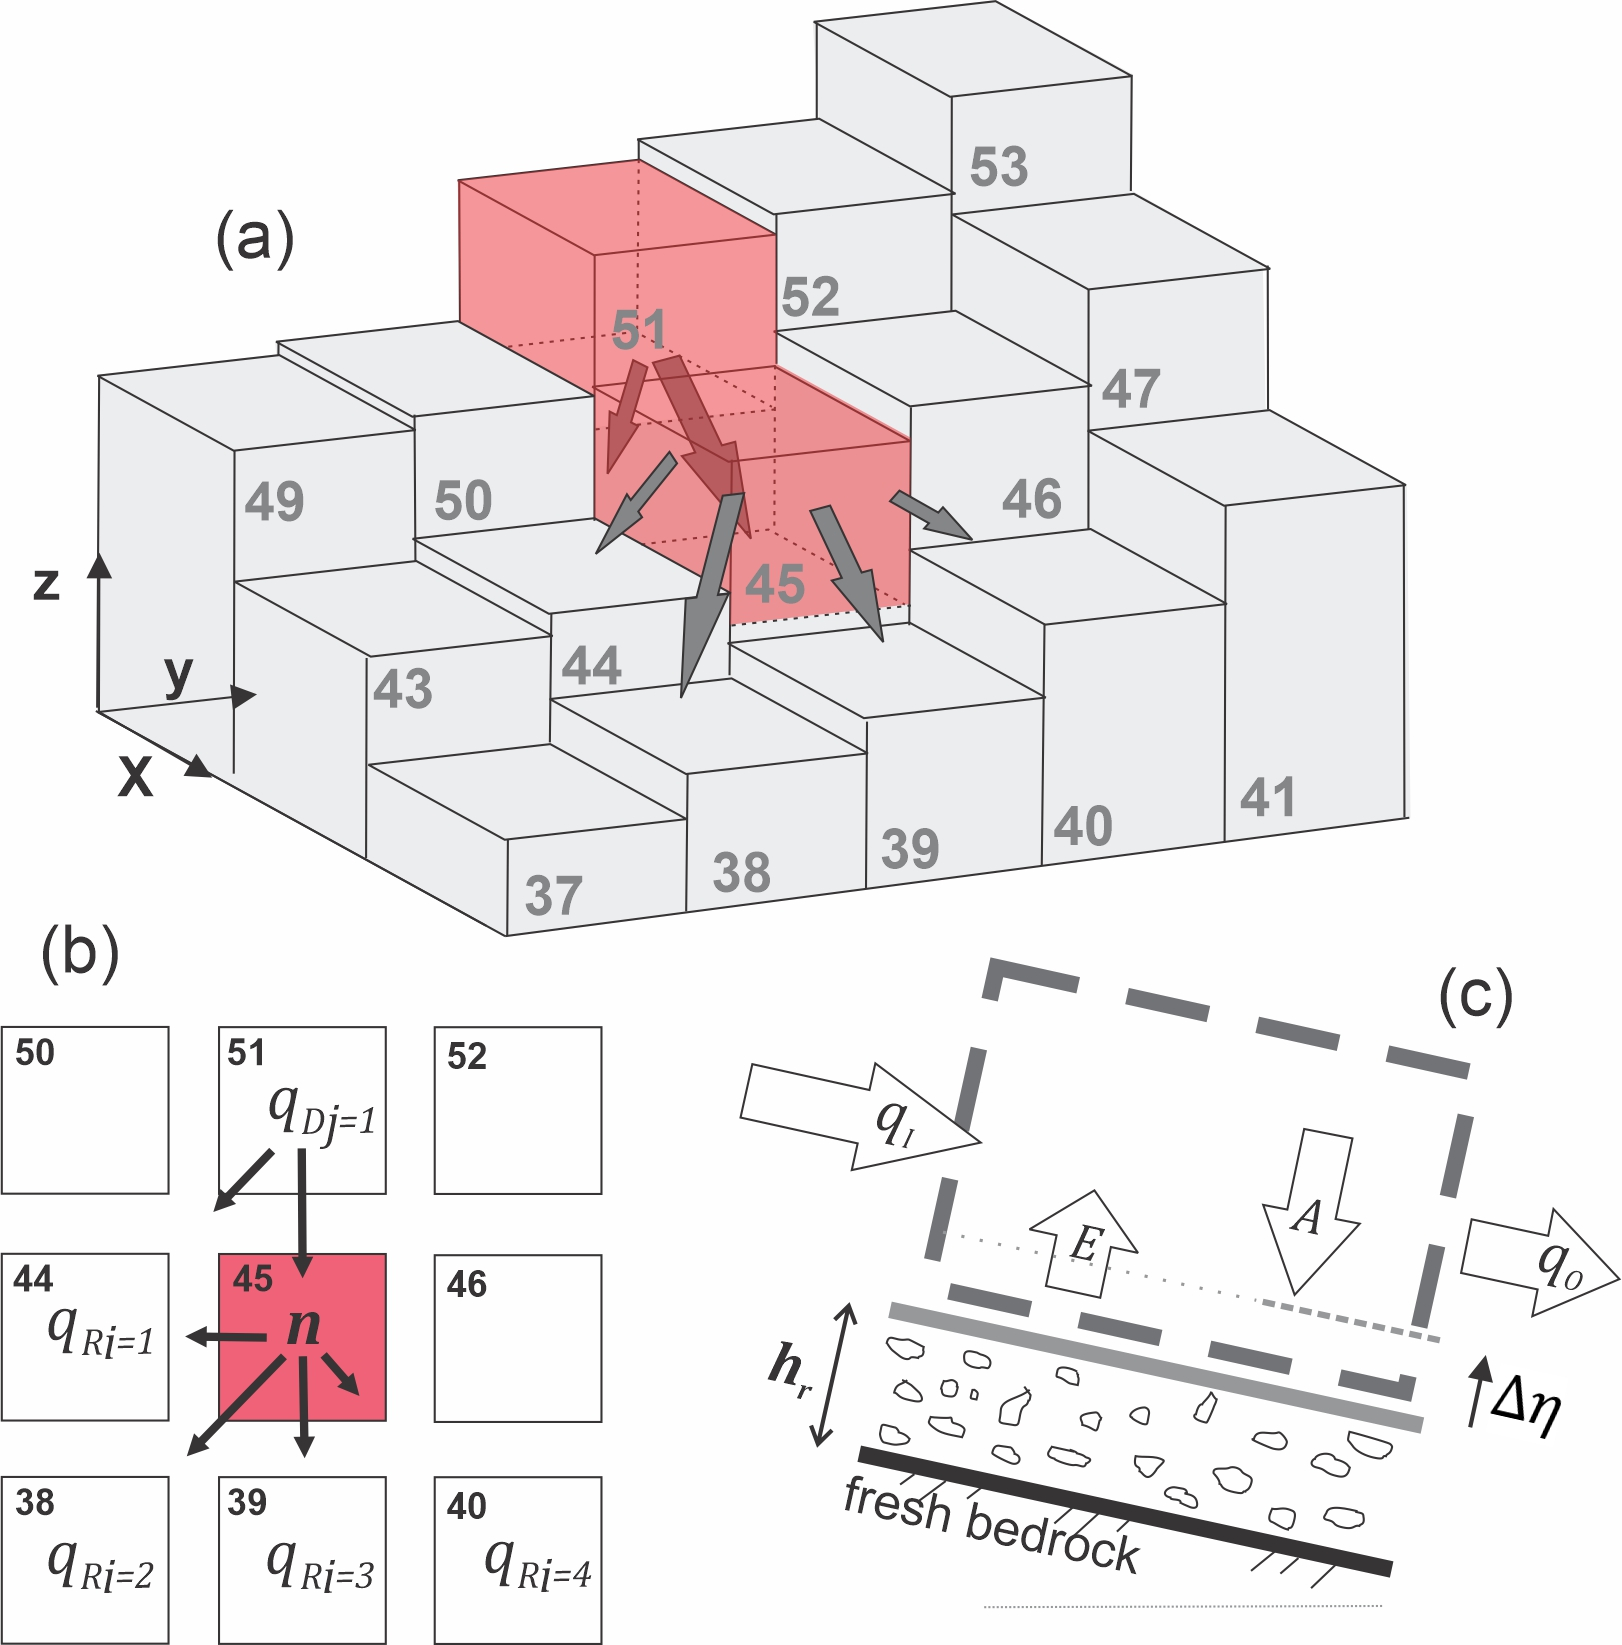
<div>                                                         

<strong><em>(a)</em></strong> Release of the initial mass wasting source material nodes (represented by red cells); <strong><em>(b)</em></strong> How q_O at node n (n = 45) is distributed downslope after incoming material q_I (here equal to flux from node 51) has aggraded (A) or eroded (E) node n; <strong><em>(c)</em></strong> Mass continuity determines the change in regolith thickness/topographic elevation. For a full description of the above parameters, see Keck et al. (2024).  

**To begin, first import  packages and components necessary to load MWR inputs, run MWR and visualize model results.**

In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

from landlab.components import FlowDirectorMFD
from landlab.components.mass_wasting_runout.mass_wasting_runout import MassWastingRunout
from landlab.io import esri_ascii

**Next, define the mass wasting source area (landslide) geometry.**

In this notebook, we define the geometry of the landslide as a rectangular prism. In later notebooks, we will use the geometry of a landslide body observed in the field.

In [2]:
ls_width = 3  # number of cells wide, must be odd number
ls_length = 5  # number of cells long
ls_h = 3  # thickness, m
soil_thickness = 2  # thickness of soil (regolith) covering synthetic terrain, m

**Then, define key MWR parameters S_c, q_c and k.**

In MWR, S_c is a critical slope constraint. For some flows, it may be possible to approximate S_c from the surface slope of observed deposits. The parameter q_c is the threshold flux for deposition, that conceptually represents the flow depth below which flow resistance is large enough to cease the forward momentum of the flow, whether in the form of frictional resistance along the base of the flow or debris and vegetation in the path of the flow. Parameter k scales the erosion rate.<br> We also specify the typical particle diameter found in the regolith because in this example, we will use an erosion rule that varies as a function of the flow grain size.

In [3]:
q_c = 0.2  # threshold flux, m
S_c = 0.03  # critical slope
k = 0.01  # erosion coefficient
Dp = 0.2  # particle diameter, m

**In this tutorial, we use the variably convergent, concave terrain**


The planimetric curvature of each terrain ranges from divergent to steeply convergent. Post MWR run, terrains are shaded with the DEM of Difference (DoD) of the initial model topography. Red indicates a positive change in the elevation of the terrain (aggradation), and blue indicates a negative change (erosion).<br>

In [4]:
terrain_id = "E"

In [5]:
terrains = {
    "A": "A_PlanarSlope.asc",
    "B": "B_PlanarSlopeWithConstriction.asc",
    "C": "C_WideFlumeWithBench.asc",
    "D": "D_ConvergentConcave.asc",
    "E": "E_VariableConvergenceConcave.asc",
    "F": "F_VaryConvergenceConvex.asc",
}
with open(terrains[terrain_id]) as fp:
    mg = esri_ascii.load(fp, name="topographic__elevation", at="node")

**Now, define a few functions that will create the landslide from the given dimensions and plot model results.**


In [6]:
# plotting functions, adapted from flow-director notebooks


def surf_plot(mg, surface="topographic__elevation", title="", zlim=None):
    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    print(f"Zmin{Z.min()}, Zmax{Z.max()}")
    color = cm.gray_r((Z - Z.min()) * 2 / (Z.max() - Z.min()))
    surf = ax.plot_surface(
        mg.x_of_node.reshape(mg.shape),
        mg.y_of_node.reshape(mg.shape),
        Z,
        rstride=1,
        cstride=1,
        facecolors=color,
        linewidth=0.0,
        antialiased=False,
        alpha=0.67,
        shade=True,
    )
    ax.view_init(elev=20, azim=-75)
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Elevation")
    ax.view_init(elev=20, azim=-75)
    plt.title(title)
    ax.set_box_aspect([0.30, 1, 0.2])
    #     if zlim:
    #         ax.set_zlim(zlim)
    ax.tick_params(axis="both", which="major", labelsize=7)
    return surf


def surf_plot_drape(
    mg,
    surface="topographic__elevation",
    shading="dem_dif_o",
    title="",
    clim=[-1, 1],
    cmtype="diverging",
    zlim=None,
    colorbar=False,
):
    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    S = mg.at_node[shading].reshape(mg.shape)
    # normalize colormap values (0 to 1) so that centered at mid point
    # between clim[0] (min) and clim[1] (max) values
    S_ = S.copy()
    S_[S > clim[1]] = clim[1]
    S_[S < clim[0]] = clim[0]
    ci = (S_ - clim[0]) / (clim[1] - clim[0])
    if cmtype == "diverging":
        color = cm.seismic(ci)  # cm.bwr(ci)
    elif cmtype == "sequential":
        color = cm.terrain(ci)
    color[ci == 0.5] = [
        0.50196078,
        0.50196078,
        0.50196078,
        1,
    ]  # set zero values to grey
    surf = ax.plot_surface(
        mg.x_of_node.reshape(mg.shape),
        mg.y_of_node.reshape(mg.shape),
        Z,
        rstride=1,
        cstride=1,
        facecolors=color,
        linewidth=0.0,
        antialiased=False,
        alpha=0.65,
        shade=False,
    )
    ax.view_init(elev=20, azim=-75)
    plt.title(title)
    ax.set_box_aspect([0.30, 1, 0.2])
    ax.tick_params(axis="both", which="major", labelsize=7)
    if colorbar:
        if cmtype == "diverging":
            m = cm.ScalarMappable(cmap=cm.bwr, norm=surf.norm)
        if cmtype == "sequential":
            m = cm.ScalarMappable(cmap=cm.terrain, norm=surf.norm)
        m.set_array(np.array(clim))
        plt.colorbar(m, ax=ax, shrink=0.25)
    return surf


# functions to define the landslide and select runout profile nodes
def ls_profile_nodes(c, ls_width):
    if ls_width == 1:
        cc = int(c / 2) + 1
        pf = mg.nodes[:, cc]
    elif (ls_width <= c) and (ls_width % 2 == 1):
        cc = []
        for i in range(ls_width):
            dif = -((ls_width) % 2) + i
            cc.append(int(c / 2) + dif + 1)
        cc = np.array(cc)
        pf = mg.nodes[:, int(c / 2) + 1]
    return pf, cc


def landslide_nodes(ls_length, cc):
    # landslide nodes
    lsn = mg.nodes[-(ls_length + 1) : -1, cc]
    return lsn

**Using the selected terrain, grain size and regolith (soil) depth inputs from above, define the raster model grid.**

Here the landslide thickness is set equal to the regolith thickness. Alternatively, the landslide thickness at each node in the landslide could be defined by providing a numpy.array of the landslide thickness values.

In [7]:
# set boundary conditions
# close all boundaries except end of flume
mg.set_closed_boundaries_at_grid_edges(True, True, True, False)
dem = mg.at_node["topographic__elevation"]

# run flow director, add slope and receiving node fields
fd = FlowDirectorMFD(mg, diagonals=True, partition_method="square_root_of_slope")
fd.run_one_step()

# soil thickness
# thickness = np.full(mg.number_of_nodes, soil_thickness)
# mg.add_field("soil__thickness", thickness, at="node")
mg.add_empty("soil__thickness", at="node")
mg.at_node["soil__thickness"].fill(soil_thickness)

# set particle diameter
# mg.at_node["particle__diameter"] = np.ones(len(mg.node_x)) * Dp
mg.add_empty("particle__diameter", at="node")
mg.at_node["particle__diameter"].fill(Dp)

# define the landslide
c = mg.number_of_node_columns - 2
pf, cc = ls_profile_nodes(c, ls_width)
lsn = landslide_nodes(ls_length, cc)

# define landslide location
# mg.at_node["mass__wasting_id"] = np.zeros(mg.number_of_nodes, dtype=int)
mg.add_zeros("mass__wasting_id", at="node", dtype=int)
mg.at_node["mass__wasting_id"][lsn] = 1

# define landslide thickness equal to the regolith thickness
mg.at_node["soil__thickness"][lsn] = ls_h

**Lets take a look at the location of the initial landslide nodes (dark grey area) relative to the flume.**

Here, the flume is colored according to elevation

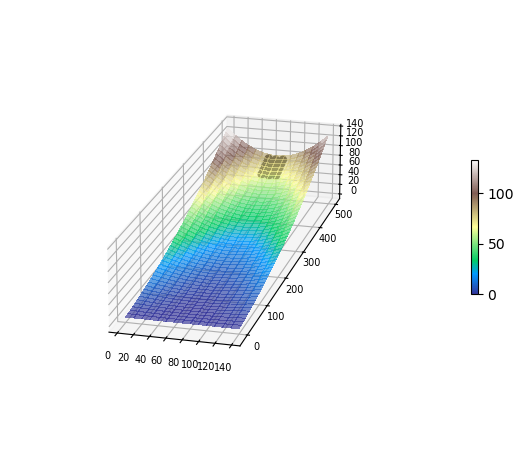

In [8]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection="3d")
surf_plot_drape(
    mg,
    surface="topographic__elevation",
    shading="topographic__elevation",
    title="",
    clim=[
        mg.at_node["topographic__elevation"].min(),
        mg.at_node["topographic__elevation"].max(),
    ],
    cmtype="sequential",
    colorbar=True,
)
ax.scatter(
    mg.node_x[lsn],
    mg.node_y[lsn] + 1,
    mg.at_node["topographic__elevation"][lsn],
    marker=".",
    color="k",
    alpha=1,
    s=100,
)

**Now set up an instance of MWR using the newly defined raster model grid and landslide and run the model!**

In [9]:
# set up the model
MWRu = MassWastingRunout(
    mg,
    critical_slope=[S_c],
    threshold_flux=q_c,
    erosion_coefficient=k,
    max_flow_depth_observed_in_field=ls_h,
    tracked_attributes=["particle__diameter"],
    effective_qsi=True,
    save=True,
    grain_shear=True,
    settle_deposit=False,
)
# run the model
#for i in range(50):
MWRu.run_one_step()

**Once the model has finished running, view the runout extent and how the landslide runout modified the terrain.**

Here the terrain is shown following the runout of the landslide and is now colored according to the DoD. Notice how the landslide removed material at its source, and except for lateral levees, eroded over most of the runout path. The runout material deposited once the slope of the terrain << S_c. Again, red indicates a positive change in the elevation of the terrain (aggradation) and blue indicates a negative change (erosion).

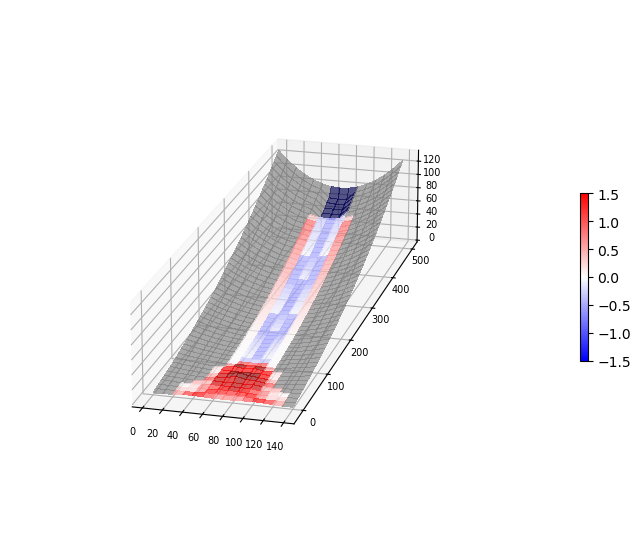

In [10]:
# Plotting the aggredation/erosion generated by mass wasting event

# Defining colorbar
clim = [-ls_h / 2, ls_h / 2]  # colorbar limits for plot, plots below use [-0.5, 0.5]

# Generating DEM of Difference
mg.at_node["dem_dif_o"] = (
    mg.at_node["topographic__elevation"] - mg.at_node["topographic__initial_elevation"]
)

# exagerate topographic change for visualization
mg.at_node["topographic__elevation_with_change"] = (
    mg.at_node["topographic__initial_elevation"] + mg.at_node["dem_dif_o"] * 3
)

# Generating figure
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection="3d")
surf = surf_plot_drape(
    mg,
    surface="topographic__elevation_with_change",
    shading="dem_dif_o",
    title="",
    clim=clim,
    colorbar=True,
)

plt.tight_layout()
plt.show()


### Part II. How do we evolve the debris flow channel?

We adopt the topographic elevation and soil thickness fields from the MWR generated grid, and create a new grid that will allow usage of  the **`PriorityFloodFlowRouter`**, **`SPACE`**, **`ExponentialWeatherer`**, **`DepthDependentTaylorDiffuser`**, and **`ChannelProfiler`** components to analyze debris flow channel evolution.

**Importing the required packages**

In [11]:
# Importing required Landlab packages
from landlab.components import (PriorityFloodFlowRouter,
                                ExponentialWeatherer,
                                DepthDependentTaylorDiffuser,
                                SpaceLargeScaleEroder,
                                ChannelProfiler,
                                )
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from landlab import imshowhs_grid, imshow_grid
import os
import time, warnings, copy
warnings.filterwarnings('ignore')

## Import Landlab utilities
from landlab import RasterModelGrid  # Grid utility
from landlab import imshowhs_grid, imshow_grid  # For plotting results; optional

**Defining printing and plotting functions**

The printing function considers the simulation time and provides a status update at every iteration.

The plotting function uses **`ChannelProfiler`** with various **`Matplotlib`** utilities to plot the change in debris thickness along the 1D longitudinal profile at each iteration.

In [12]:
# creating printing function
def print_model_progress(start_time,current_time,elapsed_time,total_t,i,ndt):
    runtime_per_step = (current_time - start_time)/i
    runtime_remaining = runtime_per_step * (ndt-i)
    runtime_remaining_mins = round(runtime_remaining/60,2)
    print("Years elapsed :   ", elapsed_time, " years (", round(elapsed_time*100/total_t,2), "%)")
    print("Runtime remaining :   ", runtime_remaining_mins, " min")
    print("--------------")
    return None
    

In [13]:
# creating plotting function for 2-D topography longitudinal profile
def plot_the_figures(grid, elapsed_time, subfolder, title="2-D topography and longitudinal profile", iteration=None):
    # Create figure and gridspec for layout
    fig = plt.figure(figsize=(16, 4))
    gs = fig.add_gridspec(1, 4, width_ratios=[1.5, 1.5, 2, 1])

    # Left panel: Topography and channel network
    ax1 = fig.add_subplot(gs[0, 0])
    profiler = ChannelProfiler(grid, number_of_watersheds=1, minimum_channel_threshold=625, main_channel_only=True)
    profiler.run_one_step()
    cmap_terrain = copy.copy(mpl.colormaps["terrain"])
    plt.sca(ax1)
    profiler.plot_profiles_in_map_view(cmap=cmap_terrain)
    ax1.set_title("Topography & main trunk", fontsize=10)

    # Right panel: Longitudinal profile and sediment thickness
    ax2 = fig.add_subplot(gs[0, 1:3])
    ax3 = ax2.twinx()

    riv_nodes = profiler.nodes[0]
    grid.at_node["bedrock_elevation"] = grid.at_node["topographic__elevation"] - grid.at_node["soil__depth"]
    dist_atNodes = profiler.distance_along_profile[0]

    el = grid.at_node["topographic__elevation"][riv_nodes]
    sd = grid.at_node["soil__depth"][riv_nodes]
    br = el - sd

    min_elevation = min(np.min(el), np.min(br))
    el_relief = el - min_elevation
    br_relief = br - min_elevation

    dist = (max(dist_atNodes) - dist_atNodes) * 1e-3  # convert to km
    brown_c = [205 / 255, 133 / 255, 63 / 255]

    ax2.fill_between(dist, np.max(el_relief), 0, color='lightgrey', label='total area')
    ax2.fill_between(dist, br_relief, 0, color='grey', label='bedrock')
    ax2.fill_between(dist, el_relief, br_relief, color=brown_c, label='colluvial material')

    lns2 = ax2.plot(dist, br_relief, color='k', label='bedrock', linewidth=0.8, zorder=3)
    lns1 = ax2.plot(dist, el_relief, color='brown', label='topo', linewidth=1, zorder=4)

    ax2.set_xlabel('Distance Along Profile (km)', fontsize=10)
    ax2.set_ylabel('Relief (m)', fontsize=10)
    ax2.set_ylim((np.min(el_relief), np.max(el_relief) * 1.1))
    ax2.tick_params(labelsize=10)

    lns3 = ax3.plot(dist, sd, color='orange', label='sediment', linewidth=2.0)  # Increased linewidth
    ax3.set_ylabel('Sediment thickness (m)', fontsize=10)
    ax3.tick_params(labelsize=10)
    ax3.set_ylim((0, 4))  

    lns = lns1 + lns2 + lns3
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, fontsize=10)
    ax2.set_ylim(bottom=0)
    ax2.set_title("Long Profile of Main Trunk", fontsize=10)

    plt.tight_layout()
    fig.suptitle(f"{title} (t = {elapsed_time:.0f} yr)", fontsize=14, x=0.4, y=1.04)

    # Define output folder and filename
    out_folder = os.path.join("Tutorial_figures", subfolder)
    os.makedirs(out_folder, exist_ok=True)

    filename = f"long_profile_t{iteration:04d}.png" if iteration is not None else "long_profile_final.png"
    save_path = os.path.join(out_folder, filename)
    plt.savefig(save_path, dpi=100, bbox_inches='tight')

    return fig


In [14]:
import os
import imageio.v2 as imageio
from IPython.display import HTML, display

def make_long_profile_gif(subfolder, duration=0.5, gif_name="long_profile_evolution.gif"):
    """
    Create and display an animated GIF from PNGs in Tutorial_figures/<subfolder>/.

    Parameters:
        subfolder (str): Name of the subfolder inside 'Tutorial_figures' where PNGs are stored.
        duration (float): Time (in seconds) between frames. Default is 0.5.
        gif_name (str): Name of the output GIF file. Default is 'long_profile_evolution.gif'.
    """
    folder_path = os.path.join("Tutorial_figures", subfolder)
    output_gif_path = os.path.join("Tutorial_figures", gif_name)

    image_files = sorted([
        f for f in os.listdir(folder_path)
        if f.startswith("long_profile_t") and f.endswith(".png")
    ])
    image_paths = [os.path.join(folder_path, f) for f in image_files]

    if not image_paths:
        print(f" No images found in {folder_path} matching 'long_profile_t*.png'")
        return

    # Create GIF
    with imageio.get_writer(output_gif_path, mode='I', duration=duration) as writer:
        for img_path in image_paths:
            image = imageio.imread(img_path)
            writer.append_data(image)

    print(f"GIF created: {output_gif_path}")

    # Display the animated GIF properly in Jupyter
    rel_path = output_gif_path.replace("\\", "/")  # fix for Windows paths in HTML
    display(HTML(f'<img src="{rel_path}" width="800" loop autoplay>'))


**Adapting the MWR generated RasterGrid for channel evolution components**

We replicate the raster **mg** into a new raster grid with the same topographic elevation and soil thickness. We define bedrock elevation as the difference between topographic elevation and soil thickness. Then we close all four boundaries, leaving one node in the bottom layer open for flow. This facilitates tracking of the "main trunk" in the debris flow channel using ChannelProfiler. Finally, we implement a suite of components to evolve it over a short timescale (50 years).  

In [15]:
rows = mg.number_of_node_rows
cols = mg.number_of_node_columns
dx = mg.dx  # node spacing in x direction
dy = mg.dy  # node spacing in y direction
new_grid = RasterModelGrid((rows, cols), dx)

# Add the field to the new grid and copy the data
new_grid.add_field("topographic__elevation", mg.at_node["topographic__elevation"].copy(),at="node")
new_grid.add_field("soil__depth", mg.at_node["soil__thickness"].copy(),at="node")
new_grid.add_field("bedrock__elevation", mg.at_node["topographic__elevation"]-mg.at_node["soil__thickness"])

# Copy boundary conditions
new_grid.set_closed_boundaries_at_grid_edges(
    right_is_closed=mg.status_at_node[mg.nodes_at_right_edge][0] == 4,
    top_is_closed=mg.status_at_node[mg.nodes_at_top_edge][0] == 4,
    left_is_closed=mg.status_at_node[mg.nodes_at_left_edge][0] == 4,
    bottom_is_closed=mg.status_at_node[mg.nodes_at_bottom_edge][0] == 4
)

new_grid.set_closed_boundaries_at_grid_edges(True, True, True, True)

# Get the bottom edge node indices
bottom_nodes = new_grid.nodes_at_bottom_edge

# Find the middle one of the bottom edge
mid_index = int(len(bottom_nodes) // 2)
mid_node = bottom_nodes[mid_index]

new_grid.status_at_node[mid_node] = 1 


In [16]:
# Setting up our parameters
## grid parameters

# time parameters
total_time = 50	# (yr)
timestep = 1 			# (yr)
ndt = int(total_time // timestep) # calculation for loop
print_output = 1	# time between printing

# uplift rate
uplift = 1e-4			# (m/yr)
uplift_per_step=uplift*timestep

# PriorityFloodFLowRouter parameters
flow_metric = "D8"
phi_FR = 0.0

# ExponentalWeatherer parameters
w_0 = 3e-4
w_star = 0.44

# DepthDependentTaylorDiffuser parameters
D = 0.01
H_transport = 0.01

# SpaceLargeScaleEroder parameters
k_sed = 1e-2 #1e-2
k_br = 1e-5
phi_sp = 0.0
F_f_sp = 0.0
H_star = 1.0 #0.1
v_s = 1 #1
m_sp = 0.45
n_sp = 1.0

# track sediment flux at the node adjacent to the outlet
node_next_to_outlet = cols + 1
ndt = int(total_time // timestep)
uplift_per_step=uplift*timestep

# ChannelProfiler parameters
number_of_watersheds = 1
minimum_channel_threshold=100

**Instantiating the suite of landlab components**

In [17]:
# Instantiating our components

# Flow routing
grid = new_grid
fr = PriorityFloodFlowRouter(
	grid,
	surface = "topographic__elevation",
	flow_metric = flow_metric,
	depression_handler = "fill",
	accumulate_flow = True,
	separate_hill_flow = True,
	accumulate_flow_hill = True,
	)

# weathering
ew = ExponentialWeatherer(
 	grid,
 	soil_production_maximum_rate = w_0,
 	soil_production_decay_depth = w_star,
	)

# diffusion
ddTd = DepthDependentTaylorDiffuser(
	grid,
	soil_transport_decay_depth = H_transport,
	nterms = 2,
	soil_transport_velocity = D,
	dynamic_dt = True,
	if_unstable = "raise",
	courant_factor = 0.9,
	)

# metrics for stream power
sp = SpaceLargeScaleEroder(
	grid,
	K_sed = k_sed,
	K_br = k_br,
	F_f = F_f_sp,
	phi = phi_sp,
	H_star = H_star,
	v_s = v_s,
	m_sp = m_sp,
	n_sp = n_sp,
	)


**2-D Representation of the adapated grid**

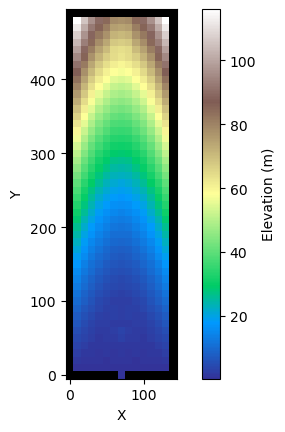

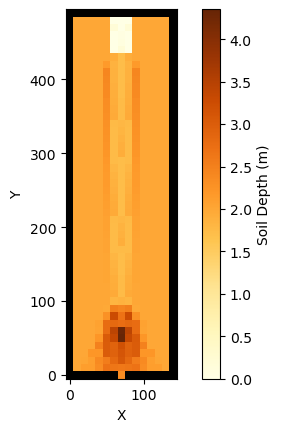

In [18]:
# plot initial grid
# set color maps for plotting
cmap_terrain = mpl.cm.get_cmap("terrain").copy()
cmap_soil = mpl.cm.get_cmap("YlOrBr").copy()
imshow_grid(grid,"topographic__elevation",var_name="Elevation",var_units="m",cmap=cmap_terrain)
plt.show()
imshow_grid(grid,"soil__depth",var_name="Soil Depth",var_units="m",cmap=cmap_soil)
plt.show()


### Example Run

Here we demonstrate an example model run with the instantiated parameter values above. Some of them are as follows:

**Temporal parameters:** We simulate for a period of **50 years**, iterating at each time step.

The **background uplift rate** is 0.1 mm/yr.

The **DepthDependentTaylorDiffuser** has diffusivity D set at 0.01.

Sediment erodibility and bedrock erodibility in **SPACE** are 0.01 and 0.00001, respectively. 



Post-landslide profile


<Figure size 640x480 with 0 Axes>

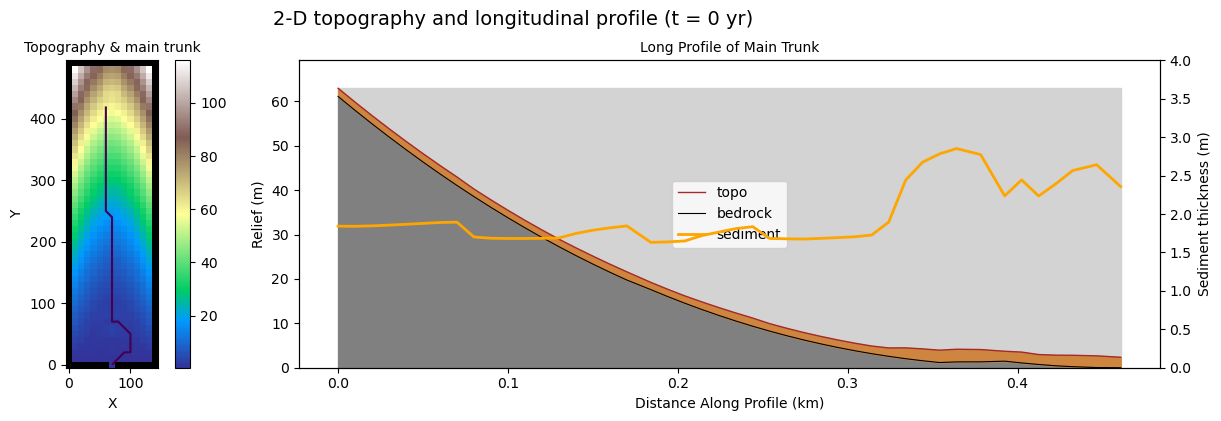

Years elapsed :    1  years ( 2.0 %)
Runtime remaining :    0.48  min
--------------
Years elapsed :    2  years ( 4.0 %)
Runtime remaining :    0.38  min
--------------
Years elapsed :    3  years ( 6.0 %)
Runtime remaining :    0.34  min
--------------
Years elapsed :    4  years ( 8.0 %)
Runtime remaining :    0.35  min
--------------
Years elapsed :    5  years ( 10.0 %)
Runtime remaining :    0.33  min
--------------
Years elapsed :    6  years ( 12.0 %)
Runtime remaining :    0.31  min
--------------
Years elapsed :    7  years ( 14.0 %)
Runtime remaining :    0.3  min
--------------
Years elapsed :    8  years ( 16.0 %)
Runtime remaining :    0.29  min
--------------
Years elapsed :    9  years ( 18.0 %)
Runtime remaining :    0.28  min
--------------
Years elapsed :    10  years ( 20.0 %)
Runtime remaining :    0.27  min
--------------
Years elapsed :    11  years ( 22.0 %)
Runtime remaining :    0.26  min
--------------
Years elapsed :    12  years ( 24.0 %)
Runtime remaining 

In [19]:
# Run model
elapsed_time = 0 			# set elapsed model time to 0 years
start_time = time.time()	# set intial timestamp, used to print progress updates

subfolder = "Example_sim"

# iterate through!
for i in range(ndt+1):
    elapsed_time = i*timestep
    # add uplift
    grid.at_node['bedrock__elevation'][grid.core_nodes] += uplift_per_step
    grid.at_node['topographic__elevation'][:] = (grid.at_node["bedrock__elevation"] + grid.at_node["soil__depth"])
    grid.at_node['topographic__elevation'][0] = 0
	# run components
    ew.run_one_step()
    ddTd.run_one_step(timestep)
    fr.run_one_step()
    sp.run_one_step(timestep)
    
	# Print progress and plot grids
    if i == 0:
        print("Post-landslide profile")
        plt.figure()
        fig = plot_the_figures(grid, elapsed_time=elapsed_time, subfolder=subfolder, iteration=i)
        plt.show()
    
    if i > 0 and i*timestep % print_output == 0:  
        current_time = time.time()
        print_model_progress(start_time, current_time, elapsed_time, total_time, i, ndt)
        fig = plot_the_figures(grid, elapsed_time=elapsed_time, subfolder=subfolder, iteration=i)
        plt.close()




#### Example simulation: Evolution of debris-flow channel

In [20]:
# Generate GIF of the iterations
make_long_profile_gif(subfolder, duration=1, gif_name="long_profile_evolution_examplesim.gif")

GIF created: Tutorial_figures/long_profile_evolution_examplesim.gif


### Part III. Exploring the model

#### Exercise 1: Changing hillslope diffusivity

Keeping other parameters from different components same as example run.

**Hillslope diffusivity (D): 0.01**

In [21]:
subfolder = "Ex1_sim/D_1e-02"

In [22]:
make_long_profile_gif(subfolder, duration=2, gif_name="long_profile_evolution_D_1e-02.gif")

GIF created: Tutorial_figures/long_profile_evolution_D_1e-02.gif


**Hillslope diffusivity (D): 0.1**

In [23]:
subfolder = "Ex1_sim/D_1e-01"

In [24]:
make_long_profile_gif(subfolder, duration=2, gif_name="long_profile_evolution_D_1e-01.gif")

GIF created: Tutorial_figures/long_profile_evolution_D_1e-01.gif


**Observations:**
The one order increase in diffusivity does not show a significant difference in evacuating debris flow. Shows the importance of SPACE-induced sediment transport over Taylor scheme hillslope diffusion.

#### Exercise 2: Changing erodibility of debris layer (K_sed)

Keeping other parameters from different components same as example run.

**Sediment debris erodibility (K_sed): 0.001**

In [25]:
subfolder = "Ex2_sim/k_sed_1e-03"

In [26]:
make_long_profile_gif(subfolder, duration=1, gif_name="long_profile_evolution_k_sed_1e-03.gif")

GIF created: Tutorial_figures/long_profile_evolution_k_sed_1e-03.gif


**Sediment debris erodibility (K_sed): 0.01**

In [27]:
subfolder = "Ex2_sim/k_sed_1e-02"

In [28]:
make_long_profile_gif(subfolder, duration=1, gif_name="long_profile_evolution_k_sed_1e-02.gif")

GIF created: Tutorial_figures/long_profile_evolution_k_sed_1e-02.gif


**Observations:**
The one order increase in erodibility drastically changes the time taken to evacuate debris from the channel. K_sed of 1e-3 shows minimal evacuation of debris within 50-year simulation time, whereas K_sed of 1e-2 shows major evacuation in half the time.

### Explore!